In [529]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [530]:
# --- 1. CSVファイル読み込み（Shift-JIS対応 + カラム整形） ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding="shift-jis")
    
    # 日付・時刻の整形
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')

    # 時刻コード → 30分単位の時刻へ変換
    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    
    return df[['datetime', 'price']]

In [531]:
# --- 2. データ読み込み（任意の年度で） ---
df1 = load_price_data('./notebook/spot_summary_2015.csv')
df2 = load_price_data('./notebook/spot_summary_2022.csv') 
df_all = pd.concat([df1, df2], ignore_index=True)

In [532]:
df_all

,datetime,price
0,2015-04-01 00:00:00,10.11
1,2015-04-01 00:30:00,10.11
2,2015-04-01 01:00:00,10.11
3,2015-04-01 01:30:00,10.11
4,2015-04-01 02:00:00,10.56
...,...,...
35083,2023-03-31 21:30:00,11.21
35084,2023-03-31 22:00:00,11.22
35085,2023-03-31 22:30:00,11.19
35086,2023-03-31 23:00:00,11.22


In [533]:
# --- 3. 補助情報 ---
df_all['month'] = df_all['datetime'].dt.month
df_all['time'] = df_all['datetime'].dt.time
df_all['date'] = df_all['datetime'].dt.date
df_all['year'] = df_all['datetime'].dt.year

df_all['is_001'] = df_all['price'] == 0.01

In [534]:
df_all

,datetime,price,month,time,date,year,is_001
0,2015-04-01 00:00:00,10.11,4,00:00:00,2015-04-01,2015,False
1,2015-04-01 00:30:00,10.11,4,00:30:00,2015-04-01,2015,False
2,2015-04-01 01:00:00,10.11,4,01:00:00,2015-04-01,2015,False
3,2015-04-01 01:30:00,10.11,4,01:30:00,2015-04-01,2015,False
4,2015-04-01 02:00:00,10.56,4,02:00:00,2015-04-01,2015,False
...,...,...,...,...,...,...,...
35083,2023-03-31 21:30:00,11.21,3,21:30:00,2023-03-31,2023,False
35084,2023-03-31 22:00:00,11.22,3,22:00:00,2023-03-31,2023,False
35085,2023-03-31 22:30:00,11.19,3,22:30:00,2023-03-31,2023,False
35086,2023-03-31 23:00:00,11.22,3,23:00:00,2023-03-31,2023,False


In [535]:
# --- 4. 月別×時間帯別の平均価格 ---
monthly_avg = df_all.groupby(['month', 'time'])['price'].mean().reset_index()
monthly_avg

,month,time,price
0,1,00:00:00,14.259677
1,1,00:30:00,13.928710
2,1,01:00:00,13.677258
3,1,01:30:00,13.686935
4,1,02:00:00,13.537742
...,...,...,...
571,12,21:30:00,17.565806
572,12,22:00:00,17.823387
573,12,22:30:00,16.933871
574,12,23:00:00,16.336774


In [536]:
# --- 5. 月別の0.01円出現回数の平均 ---
monthly_001 = df_all.groupby('month')['is_001'].sum().reset_index(name='count_001')
monthly_001['avg_count'] = (monthly_001['count_001'] / 2).astype(int)
display(monthly_001)

,month,count_001,avg_count
0,1,0,0
1,2,13,6
2,3,150,75
3,4,170,85
4,5,203,101
5,6,67,33
6,7,44,22
7,8,104,52
8,9,58,29
9,10,43,21


In [537]:
# --- 5. 月別の0.01円出現回数の平均 ---
# yearly_001 = df_all.groupby(['year','month'])['is_001'].sum().reset_index(name='count_001')
# yearly_001

In [538]:
# --- 6. 標準日生成（365日） ---
standard_dates = pd.date_range('2023-01-01', '2023-12-31', freq='D')

standard_rows = []
for date in standard_dates:
    month = date.month
    for _, row in monthly_avg[monthly_avg['month'] == month].iterrows():
        standard_rows.append({
            'datetime': datetime.combine(date, row['time']),
            'month': month,
            'time': row['time'],
            'price': row['price']
        })

df_standard = pd.DataFrame(standard_rows)

In [539]:
# --- 7. 0.01円の出現再現（月別に割り当て） ---
df_001 = df_all[df_all['is_001']]
monthly_top_times = (
    df_001.groupby(['month', 'time']).size()
    .reset_index(name='count')
    .sort_values(['month', 'count'], ascending=[True, False])
)

In [540]:
np.random.seed(42)
for month in range(1, 13):
    avg_count = monthly_001.loc[monthly_001['month'] == month, 'avg_count'].values[0]
    top_times = monthly_top_times[monthly_top_times['month'] == month]['time'].unique()[:48]
    
    idx_candidates = df_standard[
        (df_standard['month'] == month) &
        (df_standard['time'].isin(top_times))
    ].index

    if len(idx_candidates) >= avg_count:
        selected_indices = np.random.choice(idx_candidates, size=avg_count, replace=False)
        df_standard.loc[selected_indices, 'price'] = 0.01
    else:
        print(f"Warning: 月{month}に十分な候補がないため、{len(idx_candidates)}個のみ0.01円に設定")

In [541]:
# --- 8. 出力 ---
df_standard = df_standard.sort_values('datetime').reset_index(drop=True)
df_standard[['datetime', 'price']].to_csv('jepx_standard_model_seasonal.csv', index=False)

print("【完了】Shift-JISの入力形式に対応し、標準モデルを出力しました。")

【完了】Shift-JISの入力形式に対応し、標準モデルを出力しました。


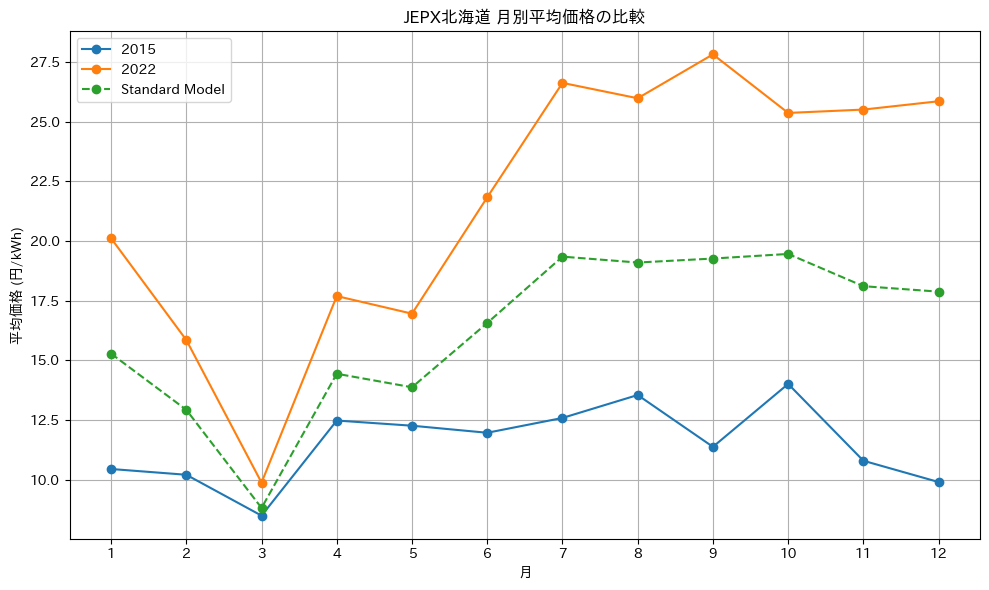

In [542]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# --- 読み込み（Shift-JIS + datetime処理） ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')
    
    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- 実績データの読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

# --- 標準モデルの読み込み ---
df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 月別平均を作成 ---
def monthly_average(df, label):
    df['month'] = df['datetime'].dt.month
    df_group = df.groupby('month')['price'].mean().reset_index()
    df_group.rename(columns={'price': label}, inplace=True)
    return df_group

avg_2015 = monthly_average(df_2015, '2015')
avg_2022 = monthly_average(df_2022, '2022')
avg_std  = monthly_average(df_std, 'Standard')

# --- マージしてプロット ---
df_plot = avg_2015.merge(avg_2022, on='month').merge(avg_std, on='month')

plt.figure(figsize=(10, 6))
plt.plot(df_plot['month'], df_plot['2015'], marker='o', label='2015')
plt.plot(df_plot['month'], df_plot['2022'], marker='o', label='2022')
plt.plot(df_plot['month'], df_plot['Standard'], marker='o', label='Standard Model', linestyle='--')

plt.title('JEPX北海道 月別平均価格の比較')
plt.xlabel('月')
plt.ylabel('平均価格 (円/kWh)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

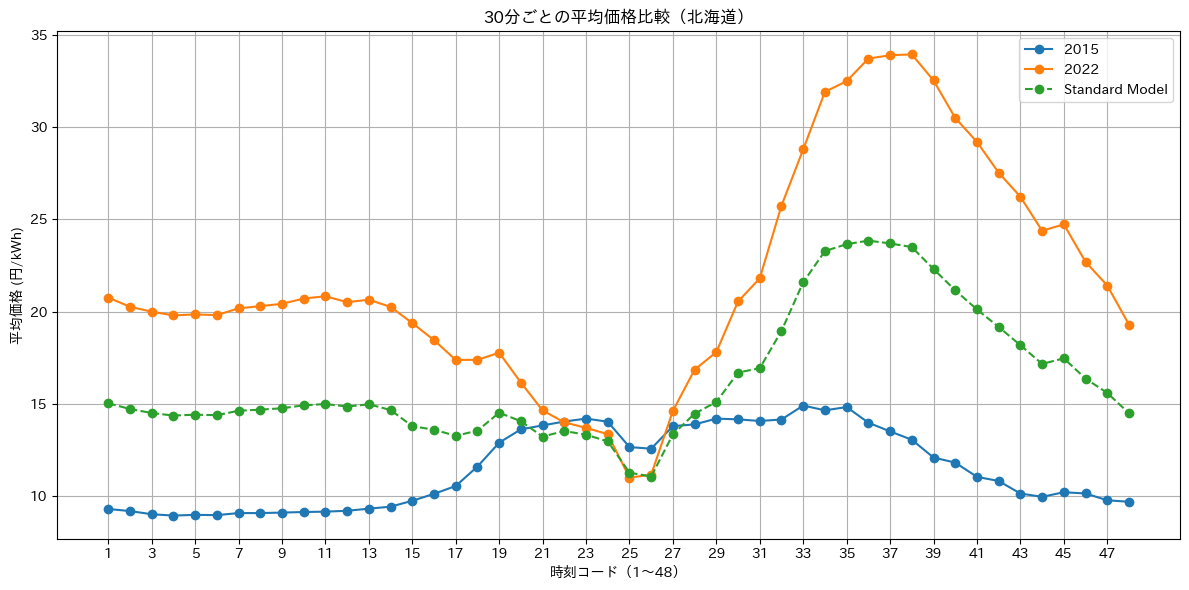

In [543]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数 ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')
    df['code'] = df['時刻コード']
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['受渡日', 'code', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')
df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])
df_std['code'] = df_std['datetime'].dt.hour * 2 + df_std['datetime'].dt.minute // 30 + 1

# --- 時刻コードごとの平均価格 ---
def avg_by_code(df, label):
    df_group = df.groupby('code')['price'].mean().reset_index()
    df_group.rename(columns={'price': label}, inplace=True)
    return df_group

avg_2015 = avg_by_code(df_2015, '2015')
avg_2022 = avg_by_code(df_2022, '2022')
avg_std  = avg_by_code(df_std, 'Standard')

# --- マージしてプロット ---
df_plot = avg_2015.merge(avg_2022, on='code').merge(avg_std, on='code')

plt.figure(figsize=(12, 6))
plt.plot(df_plot['code'], df_plot['2015'], label='2015', marker='o')
plt.plot(df_plot['code'], df_plot['2022'], label='2022', marker='o')
plt.plot(df_plot['code'], df_plot['Standard'], label='Standard Model', linestyle='--', marker='o')

plt.title('30分ごとの平均価格比較（北海道）')
plt.xlabel('時刻コード（1〜48）')
plt.ylabel('平均価格 (円/kWh)')
plt.xticks(range(1, 49, 2))  # 2刻み表示
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

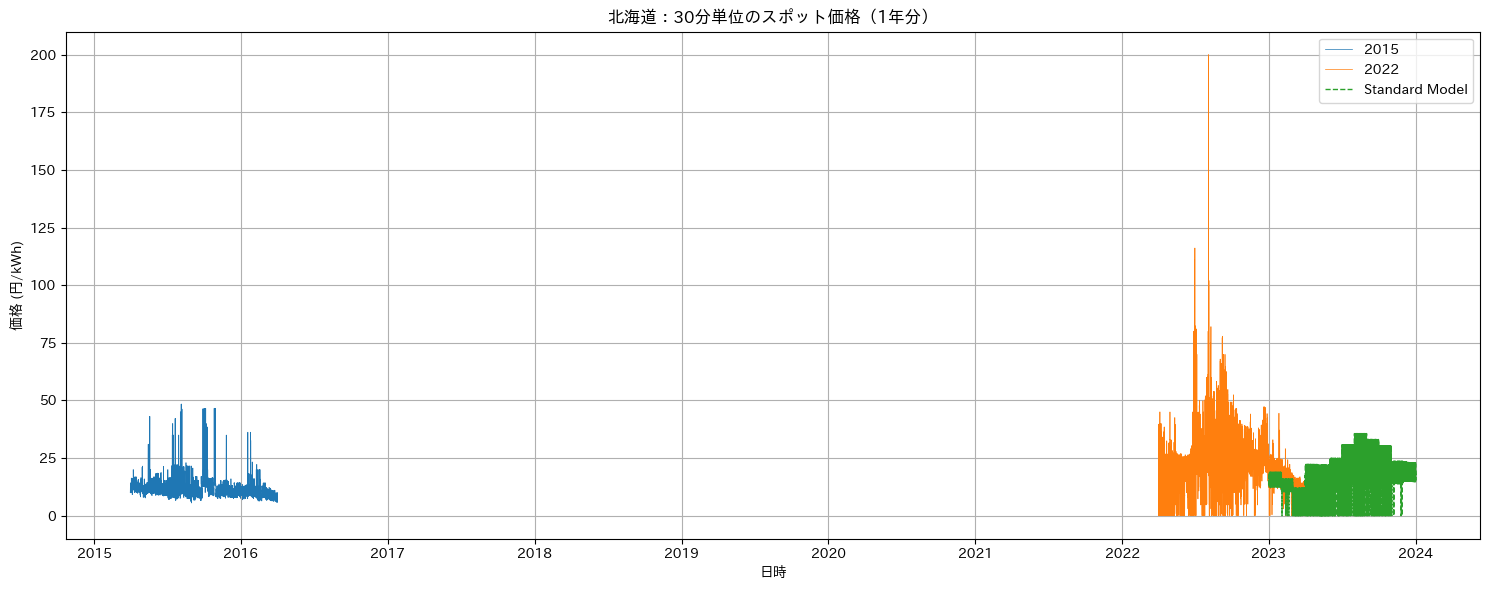

In [544]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数 ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- プロット ---
plt.figure(figsize=(15, 6))

plt.plot(df_2015['datetime'], df_2015['price'], label='2015', linewidth=0.5)
plt.plot(df_2022['datetime'], df_2022['price'], label='2022', linewidth=0.5)
plt.plot(df_std['datetime'], df_std['price'], label='Standard Model', linewidth=1.0, linestyle='--')

plt.title('北海道：30分単位のスポット価格（1年分）')
plt.xlabel('日時')
plt.ylabel('価格 (円/kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

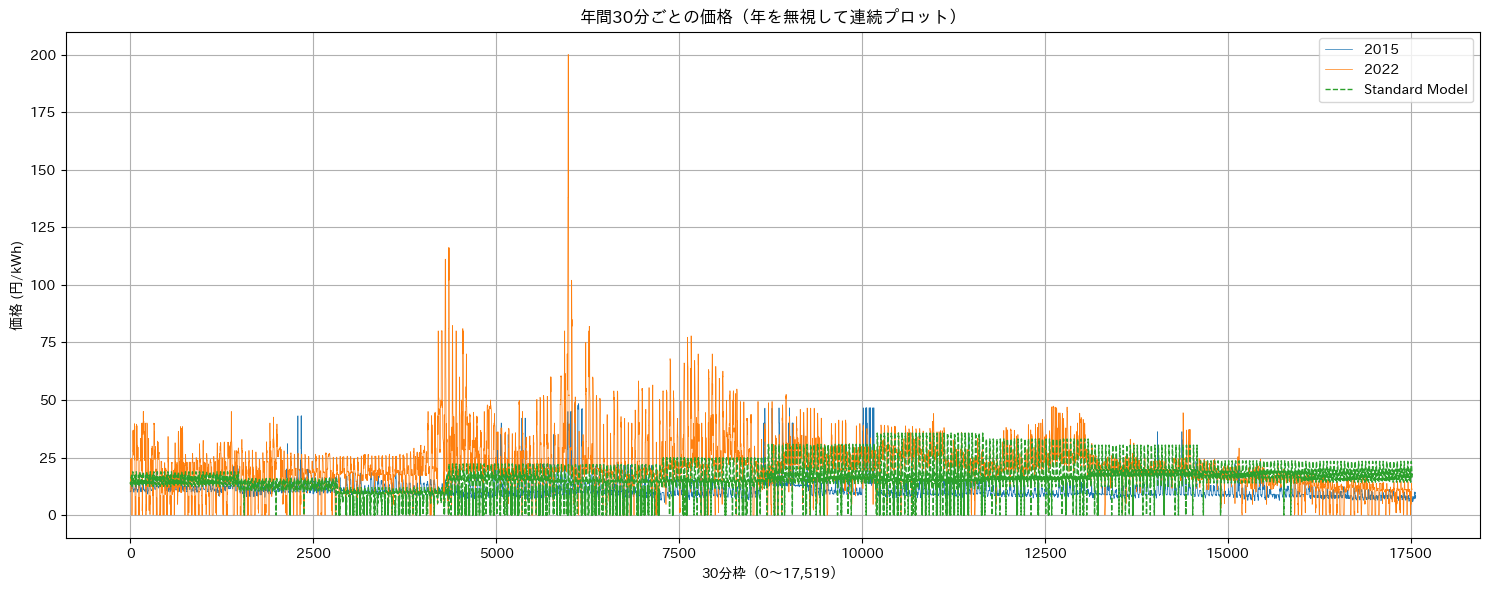

In [545]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数 ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 年を無視して "時刻順に並べる" ---
df_2015_sorted = df_2015.sort_values(by='datetime').reset_index(drop=True)
df_2022_sorted = df_2022.sort_values(by='datetime').reset_index(drop=True)
df_std_sorted  = df_std.sort_values(by='datetime').reset_index(drop=True)

# --- プロット ---
plt.figure(figsize=(15, 6))
plt.plot(df_2015_sorted.index, df_2015_sorted['price'], label='2015', linewidth=0.5)
plt.plot(df_2022_sorted.index, df_2022_sorted['price'], label='2022', linewidth=0.5)
plt.plot(df_std_sorted.index,  df_std_sorted['price'],  label='Standard Model', linestyle='--', linewidth=1.0)

plt.title('年間30分ごとの価格（年を無視して連続プロット）')
plt.xlabel('30分枠（0〜17,519）')
plt.ylabel('価格 (円/kWh)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

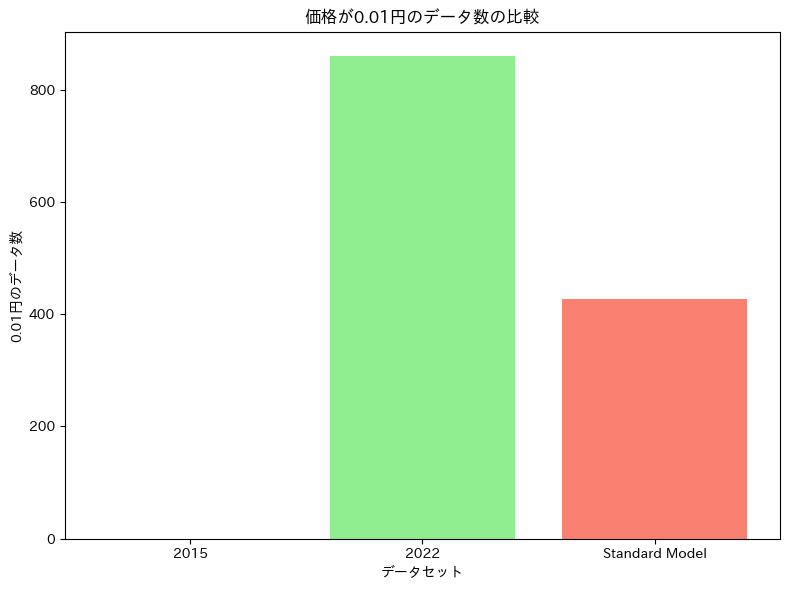

In [546]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数（%Y/%m/%d 対応）---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')  # ←日付フォーマット修正

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 0.01円の価格の数をカウント ---
count_2015 = (df_2015['price'] == 0.01).sum()
count_2022 = (df_2022['price'] == 0.01).sum()
count_std  = (df_std['price'] == 0.01).sum()

# --- 棒グラフで表示 ---
plt.figure(figsize=(8, 6))
labels = ['2015', '2022', 'Standard Model']
counts = [count_2015, count_2022, count_std]

plt.bar(labels, counts, color=['skyblue', 'lightgreen', 'salmon'])

plt.title('価格が0.01円のデータ数の比較')
plt.xlabel('データセット')
plt.ylabel('0.01円のデータ数')
plt.tight_layout()
plt.show()

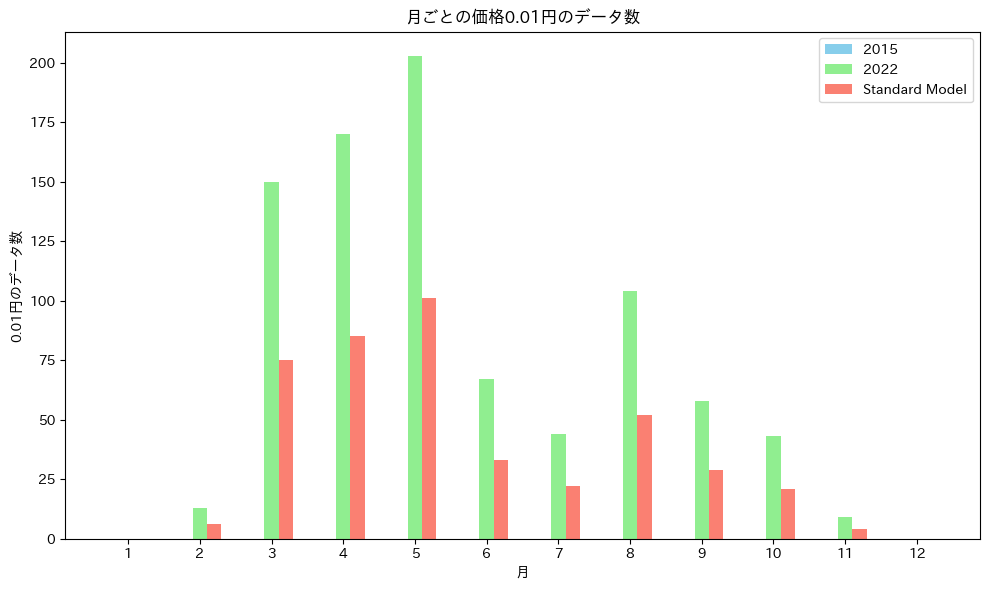

In [547]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数（%Y/%m/%d 対応）---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')  # ←日付フォーマット修正

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 0.01円の価格のデータを月ごとにカウント ---
def count_zero_point_one(df):
    df['month'] = df['datetime'].dt.month
    return df[df['price'] == 0.01].groupby('month').size()

# --- 各データセットの月ごとのカウント ---
count_2015_month = count_zero_point_one(df_2015)
count_2022_month = count_zero_point_one(df_2022)
count_std_month  = count_zero_point_one(df_std)

# --- 月ごとに棒グラフで表示 ---
plt.figure(figsize=(10, 6))

# 月をリストに変換
months = list(range(1, 13))

# グラフに足りない月を0として追加
count_2015_month = count_2015_month.reindex(months, fill_value=0)
count_2022_month = count_2022_month.reindex(months, fill_value=0)
count_std_month = count_std_month.reindex(months, fill_value=0)

plt.bar([x - 0.2 for x in months], count_2015_month, width=0.2, label='2015', color='skyblue')
plt.bar(months, count_2022_month, width=0.2, label='2022', color='lightgreen')
plt.bar([x + 0.2 for x in months], count_std_month, width=0.2, label='Standard Model', color='salmon')

plt.title('月ごとの価格0.01円のデータ数')
plt.xlabel('月')
plt.ylabel('0.01円のデータ数')
plt.xticks(months)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2075334794.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015_may['datetime'] = df_2015_may['datetime'].dt.strftime('%m/%d %H:%M')
C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2075334794.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022_may['datetime'] = df_2022_may['datetime'].dt.strftime('%m/%d %H:%M')
C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2075334794.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of

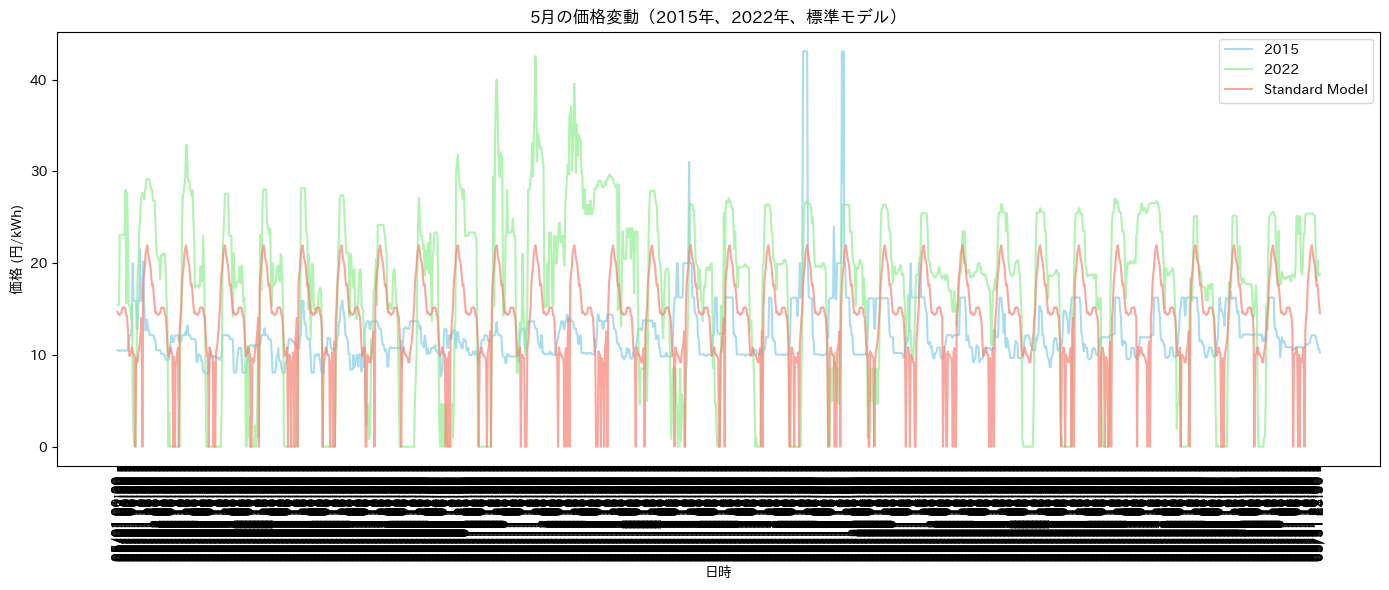

In [548]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数（%Y/%m/%d 対応）---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')  # ←日付フォーマット修正

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 5月のデータを抽出（各年、標準モデル）---
def get_may_data(df):
    df['month'] = df['datetime'].dt.month
    return df[df['month'] == 5]

df_2015_may = get_may_data(df_2015)
df_2022_may = get_may_data(df_2022)
df_std_may = get_may_data(df_std)

# --- 年を無視して、5月の時刻ごとの価格変動を重ねてプロット ---
# 年を無視して、datetimeの年を削除（5月の時刻ごとの価格変動を重ねる）
df_2015_may['datetime'] = df_2015_may['datetime'].dt.strftime('%m/%d %H:%M')
df_2022_may['datetime'] = df_2022_may['datetime'].dt.strftime('%m/%d %H:%M')
df_std_may['datetime'] = df_std_may['datetime'].dt.strftime('%m/%d %H:%M')

# プロット
plt.figure(figsize=(14, 6))
plt.plot(df_2015_may['datetime'], df_2015_may['price'], label='2015', color='skyblue', alpha=0.7)
plt.plot(df_2022_may['datetime'], df_2022_may['price'], label='2022', color='lightgreen', alpha=0.7)
plt.plot(df_std_may['datetime'], df_std_may['price'], label='Standard Model', color='salmon', alpha=0.7)

# 設定
plt.title('5月の価格変動（2015年、2022年、標準モデル）')
plt.xlabel('日時')
plt.ylabel('価格 (円/kWh)')
plt.xticks(rotation=90)  # 時刻ラベルを回転
plt.legend()
plt.tight_layout()

# 表示
plt.show()

C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2386051921.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2015_may['datetime'] = df_2015_may['datetime'].dt.strftime('%m/%d %H:%M')
C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2386051921.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022_may['datetime'] = df_2022_may['datetime'].dt.strftime('%m/%d %H:%M')
C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2386051921.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of

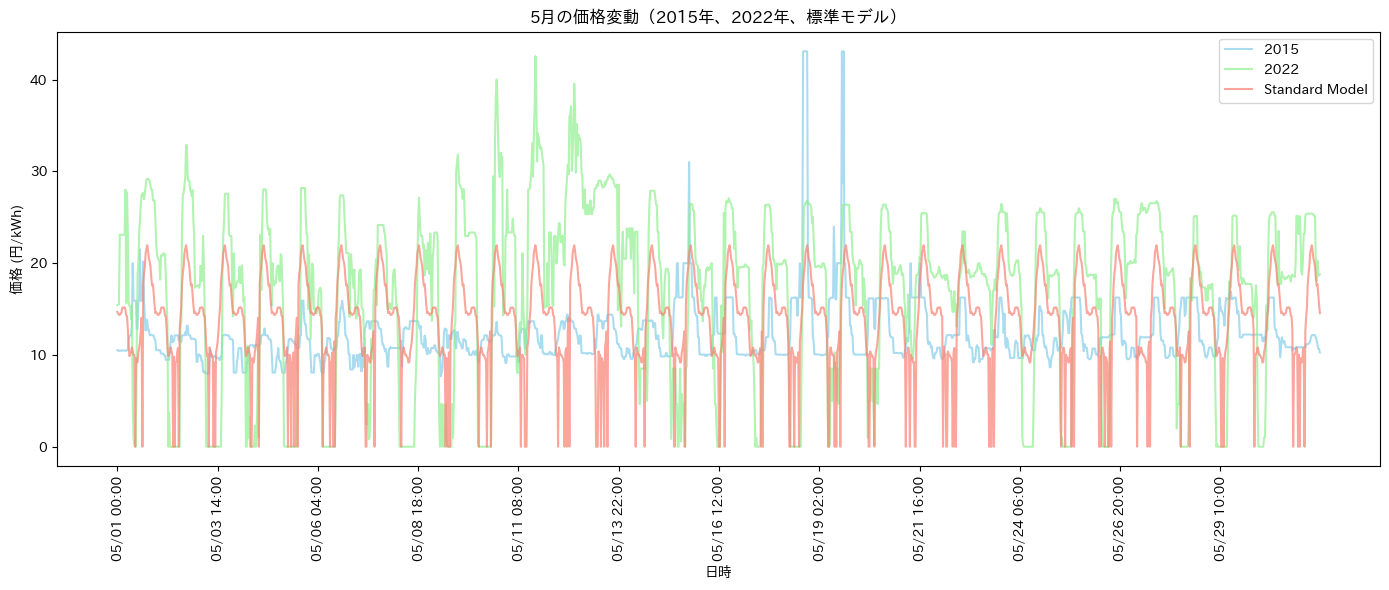

In [549]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数（%Y/%m/%d 対応）---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')  # ←日付フォーマット修正

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')

df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 5月のデータを抽出（各年、標準モデル）---
def get_may_data(df):
    df['month'] = df['datetime'].dt.month
    return df[df['month'] == 5]

df_2015_may = get_may_data(df_2015)
df_2022_may = get_may_data(df_2022)
df_std_may = get_may_data(df_std)

# --- 年を無視して、5月の時刻ごとの価格変動を重ねてプロット ---
# 年を無視して、datetimeの年を削除（5月の時刻ごとの価格変動を重ねる）
df_2015_may['datetime'] = df_2015_may['datetime'].dt.strftime('%m/%d %H:%M')
df_2022_may['datetime'] = df_2022_may['datetime'].dt.strftime('%m/%d %H:%M')
df_std_may['datetime'] = df_std_may['datetime'].dt.strftime('%m/%d %H:%M')

# プロット
plt.figure(figsize=(14, 6))
plt.plot(df_2015_may['datetime'], df_2015_may['price'], label='2015', color='skyblue', alpha=0.7)
plt.plot(df_2022_may['datetime'], df_2022_may['price'], label='2022', color='lightgreen', alpha=0.7)
plt.plot(df_std_may['datetime'], df_std_may['price'], label='Standard Model', color='salmon', alpha=0.7)

# 横軸を12:00, 00:00区切りで表示するための調整
plt.xticks(rotation=90)  # ラベルを回転して見やすくする

# 横軸に時間を12:00, 00:00区切りで表示
plt.xticks([i for i in range(0, len(df_2015_may['datetime']), len(df_2015_may)//12)], df_2015_may['datetime'][::len(df_2015_may)//12])

# 設定
plt.title('5月の価格変動（2015年、2022年、標準モデル）')
plt.xlabel('日時')
plt.ylabel('価格 (円/kWh)')
plt.legend()
plt.tight_layout()

# 表示
plt.show()

C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\2079103332.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start='2023-05-01 00:00', end='2023-06-01 00:00', freq='12H')


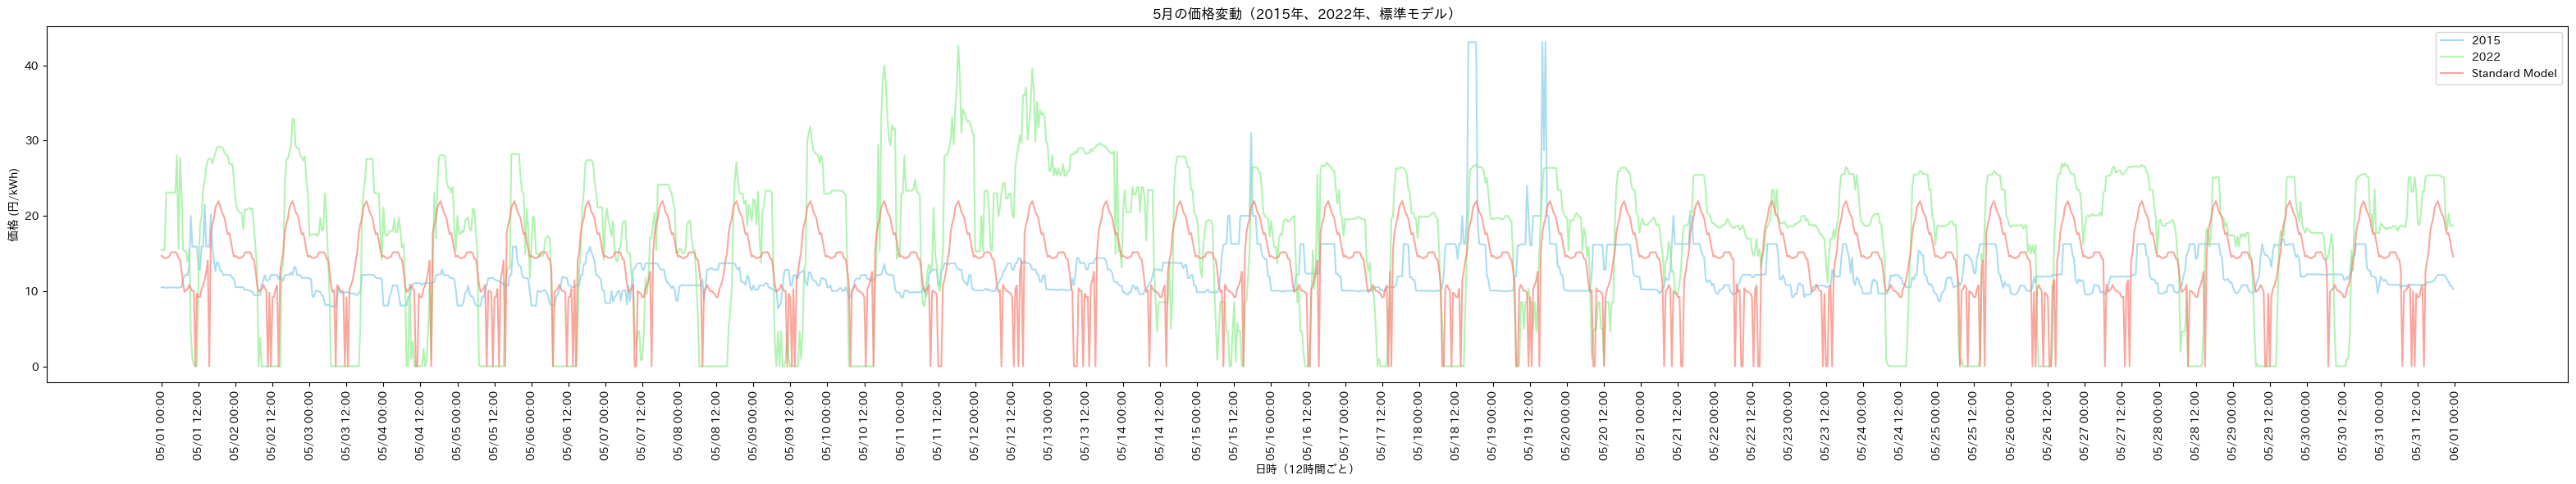

In [551]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数 ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')
df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 5月データ抽出 & 仮想datetimeに統一（年を2023に固定）---
def prepare_may(df):
    df = df[df['datetime'].dt.month == 5].copy()
    df['virtual_datetime'] = pd.date_range(start='2023-05-01 00:00', periods=len(df), freq='30min')
    return df

df_2015_may = prepare_may(df_2015)
df_2022_may = prepare_may(df_2022)
df_std_may = prepare_may(df_std)

# --- プロット ---
plt.figure(figsize=(31.5, 6))  # 横幅1.5倍

plt.plot(df_2015_may['virtual_datetime'], df_2015_may['price'], label='2015', color='skyblue', alpha=0.7)
plt.plot(df_2022_may['virtual_datetime'], df_2022_may['price'], label='2022', color='lightgreen', alpha=0.7)
plt.plot(df_std_may['virtual_datetime'], df_std_may['price'], label='Standard Model', color='salmon', alpha=0.7)

# 横軸12時間ごとのラベル
xticks = pd.date_range(start='2023-05-01 00:00', end='2023-06-01 00:00', freq='12H')
plt.xticks(xticks, [dt.strftime('%m/%d %H:%M') for dt in xticks], rotation=90)

plt.title('5月の価格変動（2015年、2022年、標準モデル）')
plt.xlabel('日時（12時間ごと）')
plt.ylabel('価格 (円/kWh)')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\tsuki\AppData\Local\Temp\ipykernel_8368\111602465.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start='2023-06-01 00:00', end='2023-07-01 00:00', freq='12H')


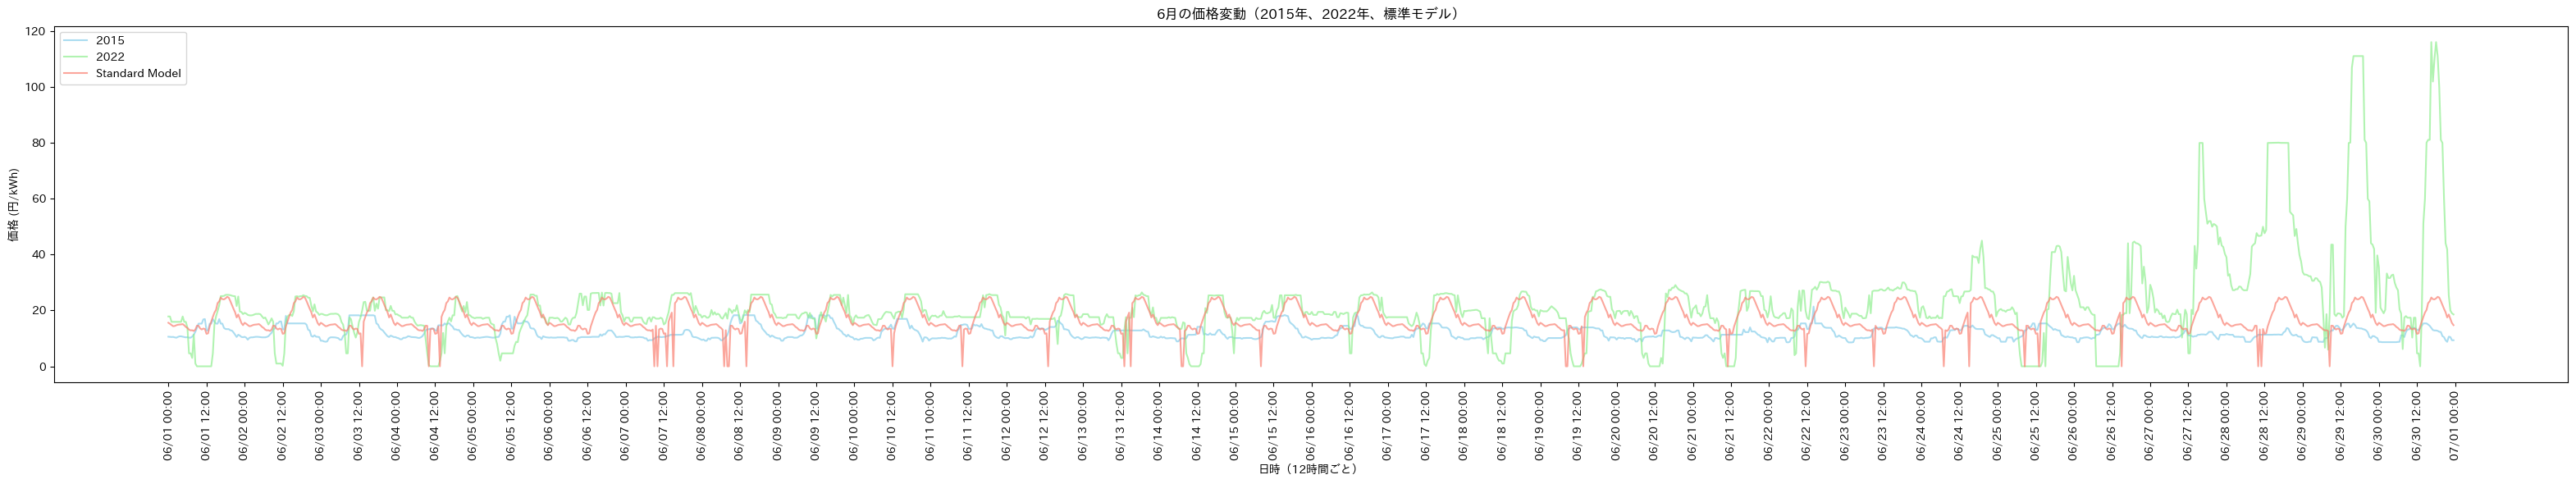

In [552]:
import pandas as pd
import matplotlib.pyplot as plt

# --- データ読み込み関数 ---
def load_price_data(file_path):
    df = pd.read_csv(file_path, encoding='shift-jis')
    df['受渡日'] = pd.to_datetime(df['受渡日'], format='%Y/%m/%d')

    def time_from_code(code):
        hour = (code - 1) // 2
        minute = 30 * ((code - 1) % 2)
        return f"{hour:02d}:{minute:02d}"

    df['time'] = df['時刻コード'].apply(time_from_code)
    df['datetime'] = pd.to_datetime(df['受渡日'].astype(str) + ' ' + df['time'])
    df['price'] = df['エリアプライス北海道(円/kWh)']
    return df[['datetime', 'price']]

# --- データ読み込み ---
df_2015 = load_price_data('./notebook/spot_summary_2015.csv')
df_2022 = load_price_data('./notebook/spot_summary_2022.csv')
df_std = pd.read_csv('jepx_standard_model_seasonal.csv')
df_std['datetime'] = pd.to_datetime(df_std['datetime'])

# --- 6月データ抽出 & 仮想datetimeに統一（年を2023に固定）---
def prepare_june(df):
    df = df[df['datetime'].dt.month == 6].copy()
    df['virtual_datetime'] = pd.date_range(start='2023-06-01 00:00', periods=len(df), freq='30min')
    return df

df_2015_june = prepare_june(df_2015)
df_2022_june = prepare_june(df_2022)
df_std_june = prepare_june(df_std)

# --- プロット ---
plt.figure(figsize=(31.5, 6))  # 横幅1.5倍

plt.plot(df_2015_june['virtual_datetime'], df_2015_june['price'], label='2015', color='skyblue', alpha=0.7)
plt.plot(df_2022_june['virtual_datetime'], df_2022_june['price'], label='2022', color='lightgreen', alpha=0.7)
plt.plot(df_std_june['virtual_datetime'], df_std_june['price'], label='Standard Model', color='salmon', alpha=0.7)

# 横軸：12時間ごとの目盛り
xticks = pd.date_range(start='2023-06-01 00:00', end='2023-07-01 00:00', freq='12H')
plt.xticks(xticks, [dt.strftime('%m/%d %H:%M') for dt in xticks], rotation=90)

plt.title('6月の価格変動（2015年、2022年、標準モデル）')
plt.xlabel('日時（12時間ごと）')
plt.ylabel('価格 (円/kWh)')
plt.legend()
plt.tight_layout()
plt.show()